In [189]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU,Dense,Flatten,InputLayer,Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [334]:
from importlib import reload 
import Cf_Explain
reload(Cf_Explain)
import Cf_Explain as cfExp


In [301]:
df = pd.read_csv('../Data/Power_Consumption/powerconsumption.csv')

df.dropna()
df.drop(columns=['PowerConsumption_Zone1'], inplace=True)
df.drop(columns=['PowerConsumption_Zone3'], inplace=True)
df.rename(columns={'PowerConsumption_Zone2': 'PowerConsumption'}, inplace=True)

df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

df = df.groupby(pd.Grouper(freq='d')).agg({
    'Temperature': 'mean',
    'Humidity': 'mean',
    'WindSpeed': 'mean',
    'GeneralDiffuseFlows': 'mean',
    'DiffuseFlows': 'mean',
    'PowerConsumption': 'sum'
})

df

,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,PowerConsumption
Datetime,,,,,,
2017-01-01,9.675299,68.519306,0.315146,121.390771,25.993924,2.554242e+06
2017-01-02,12.476875,71.456319,0.076563,120.404486,27.227410,2.816312e+06
2017-01-03,12.100000,74.981667,0.076715,120.686014,28.574660,2.888247e+06
2017-01-04,10.509479,75.459792,0.082417,122.959319,28.827222,2.894699e+06
2017-01-05,10.866444,71.040486,0.083896,118.749861,29.741437,2.884888e+06
...,...,...,...,...,...,...
2017-12-26,11.621840,69.070903,0.083062,106.836687,50.760389,3.565009e+06
2017-12-27,15.232917,59.445903,0.082028,95.890674,41.705062,3.608277e+06
2017-12-28,13.662361,62.839375,0.081354,112.620160,30.209361,3.540276e+06


In [302]:
input_features=['Temperature', 'Humidity', 'WindSpeed', 'GeneralDiffuseFlows','DiffuseFlows']
output="PowerConsumption"



In [303]:
input_features

['Temperature', 'Humidity', 'WindSpeed', 'GeneralDiffuseFlows', 'DiffuseFlows']

In [304]:
from importlib import reload 
import Generate_models
reload(Generate_models)


<module 'Generate_models' from 'c:\\Users\\sarbaoui01\\Cf_Exp\\L-ontologie-de-validation-des-explications-contrefactuelles\\Code\\Generate_models.py'>

In [311]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense, Dropout, BatchNormalization, MaxPooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Define the CNN model
model = Sequential()

# First Convolutional Layer
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='same', input_shape=(20, 5)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))

# Second Convolutional Layer
model.add(Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))
model.add(LSTM(100,activation='relu'))
# Flatten the output to feed into Dense layers
model.add(Flatten())

# Fully Connected Layers
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))

# Output Layer
model.add(Dense(5, activation='relu'))  # Assuming 5 output features

# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mae', metrics=['mae', 'mse'])

c:\Users\sarbaoui01\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [312]:
model.summary()

Model: "sequential_56"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_8 (Conv1D)               │ (None, 20, 64)         │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_32          │ (None, 20, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_8 (MaxPooling1D)  │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_62 (Dropout)            │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 10, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_33          │ (None, 10, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_9 (MaxPooling1D)  │ (None, 5, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_63 (Dropout)            │ (None, 5, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_79 (LSTM)                  │ (None, 100)            │        91,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_12 (Flatten)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_158 (Dense)               │ (None, 64)             │         6,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_64 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_159 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_65 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_160 (Dense)               │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 126,805 (495.33 KB)

 Trainable params: 126,421 (493.83 KB)

 Non-trainable params: 384 (1.50 KB)

In [313]:
input_features

['Temperature', 'Humidity', 'WindSpeed', 'GeneralDiffuseFlows', 'DiffuseFlows']

In [314]:
Gm=Generate_models.Generate_model(data=df,input_features=input_features,output=output,categorical_features=[],test_size=0.3,n_steps_in=20,n_steps_out=5,dType="sequence")

In [315]:
model,xtrain,ytrain,xtest,ytest,encoder,norm=Gm.build_model(model=model,epochs=600)

Epoch 1/600
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 0.3842 - mae: 0.3842 - mse: 0.2001 - val_loss: 0.4424 - val_mae: 0.4424 - val_mse: 0.2383
Epoch 2/600
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.3399 - mae: 0.3399 - mse: 0.1631 - val_loss: 0.4320 - val_mae: 0.4320 - val_mse: 0.2288
Epoch 3/600
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.3180 - mae: 0.3180 - mse: 0.1514 - val_loss: 0.4237 - val_mae: 0.4237 - val_mse: 0.2212
Epoch 4/600
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.2688 - mae: 0.2688 - mse: 0.1132 - val_loss: 0.4183 - val_mae: 0.4183 - val_mse: 0.2167
Epoch 5/600
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.2568 - mae: 0.2568 - mse: 0.1061 - val_loss: 0.4113 - val_mae: 0.4113 - val_mse: 0.2109
Epoch 6/600
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.2539 - mae: 0.2539 - mse: 0.1021 - val_loss: 0.4002 - val_mae: 0.4002 - val_mse: 0.2015
Epoch 7/600
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.2284 - mae: 0.2284 - mse: 0.0839 - val_loss: 0.3890 

In [317]:
model.save("..\\Data\\Model\\power_consumption.keras")

In [309]:
from tensorflow.keras.models import load_model

In [318]:

model=load_model("..\\Data\\Model\\power_consumption.keras")

In [348]:
from tensorflow.keras.utils import plot_model

# Assuming 'model' is your Keras model
plot_model(model, to_file="model_architecture.pdf", show_shapes=True, show_layer_names=True, dpi=300)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


In [349]:

query_instance1=xtest[4]
pr1=np.array(model.predict(np.reshape(query_instance1,(1,20,5)), verbose=0)).flatten()
query_instance2=xtest[1]
pr11=np.array(model.predict(np.reshape(query_instance2,(1,20,5)), verbose=0)).flatten()
pr1,pr11

(array([0.38420025, 0.39789388, 0.41899318, 0.43284044, 0.43764716],
       dtype=float32),
 array([0.36580625, 0.3744267 , 0.3919867 , 0.4045457 , 0.41133654],
       dtype=float32))

In [350]:
population=np.concatenate((xtrain[0:50],xtest[5:50]))

In [351]:
ex=cfExp.ExplainCf(
    query_instance=query_instance1,
    model=model,
    population=population,
    Total_cf=20,
    direction="less",
    feature_name=input_features)



In [352]:
cefs,index,fitness=ex.conterfactual_generation_GENO_TOPSIS()

evaluating...: 100%|██████████| 20/20 [00:01<00:00, 10.87it/s]


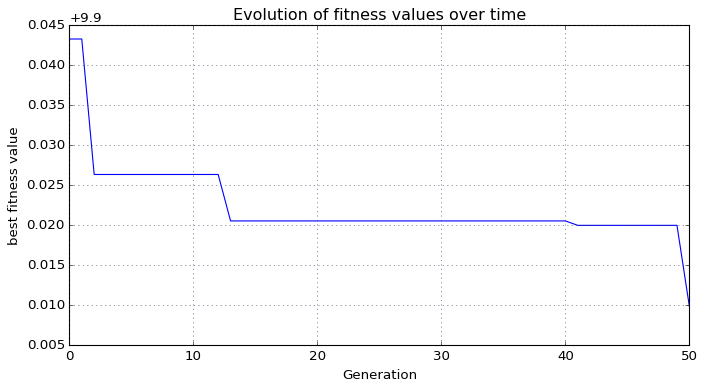

In [353]:
ex.Visualize_fitness(fitness)

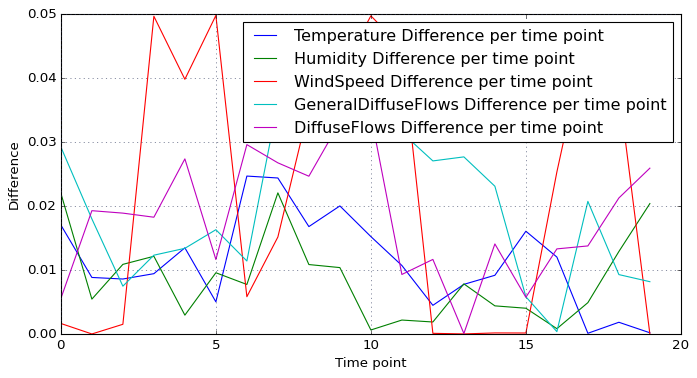

In [354]:
ex.VisualizeDifferencePerTime(cefs,0)

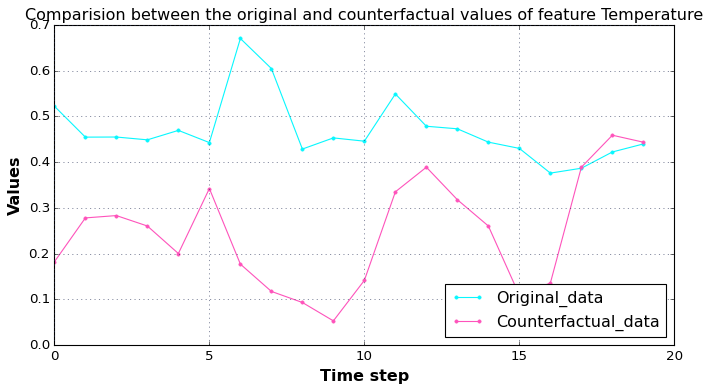

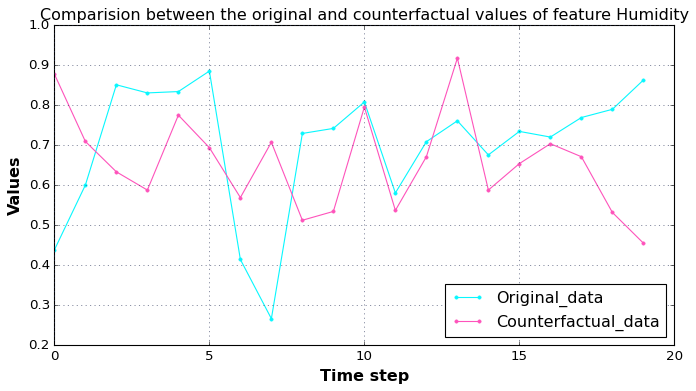

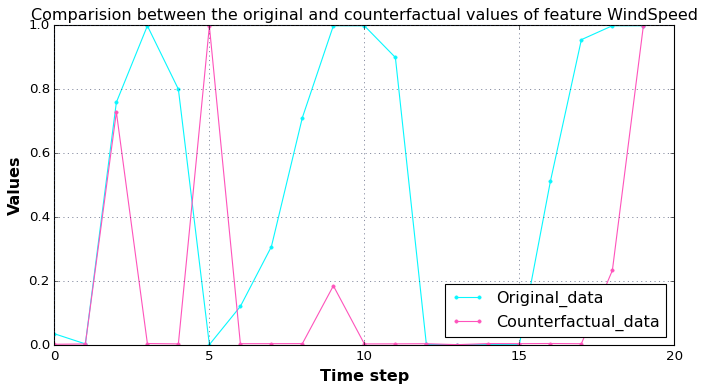

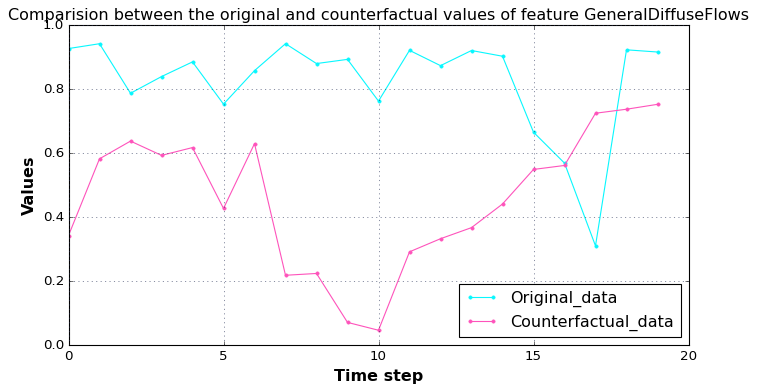

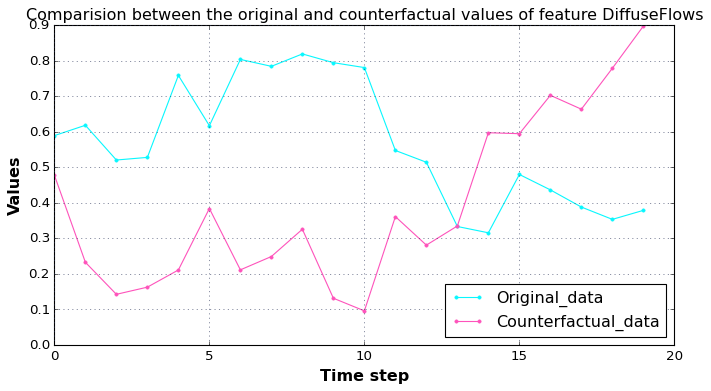

In [355]:
ex.VisualizeComparision(cefs=cefs,index=0,startTime=0)

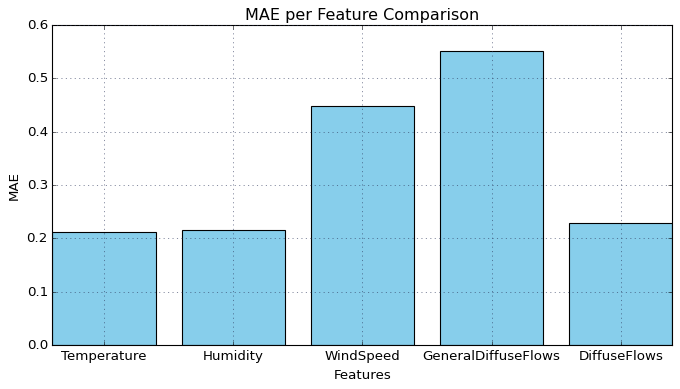

In [375]:
ex.VisualizeMAEPerFeature(cefs,17)

analysing...: 100%|██████████| 20/20 [00:05<00:00,  3.51it/s]


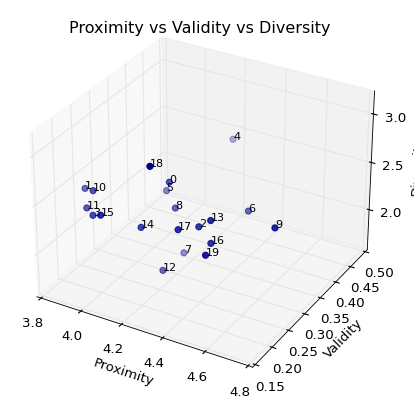

In [357]:
ex.VisualizeDistribution(cefs)

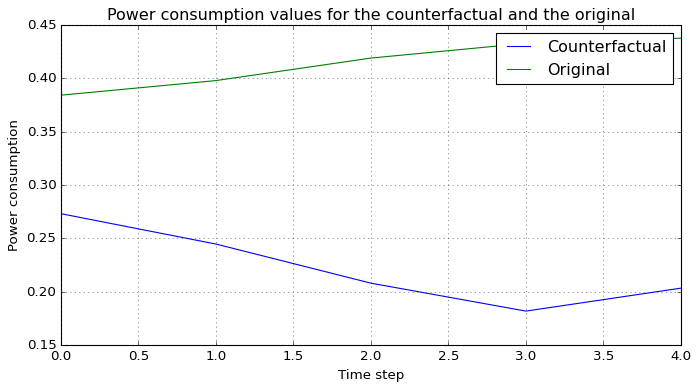

In [359]:
ex.VisualizePrediction(cefs,4,"Power consumption")

In [376]:
cefs2=ex.conterfactual_generation_NSGA2()

generating...: 100%|██████████| 50/50 [02:35<00:00,  3.10s/it]


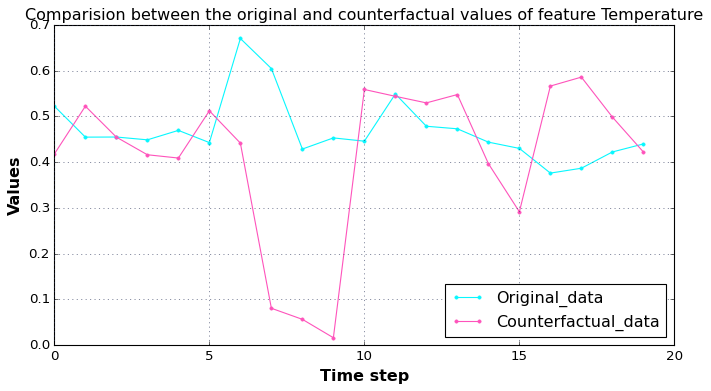

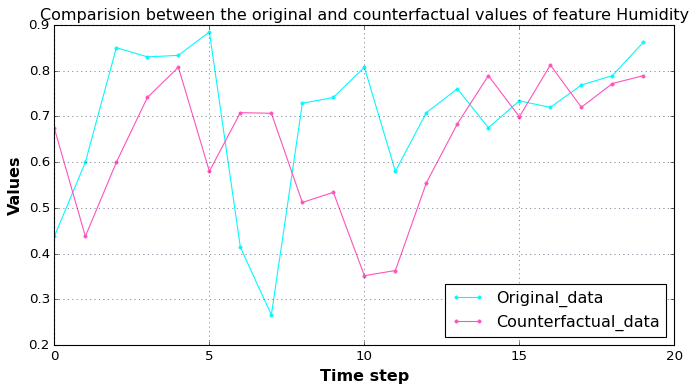

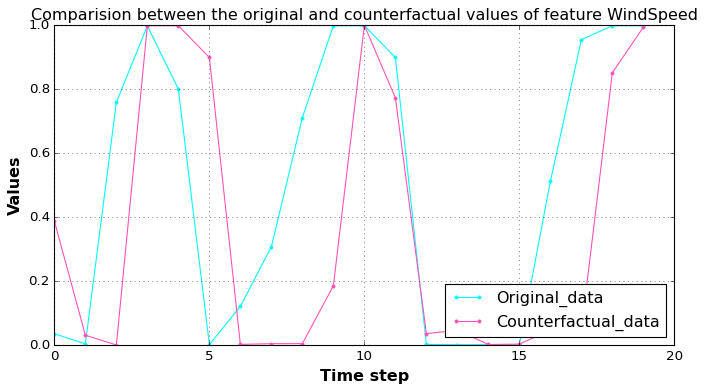

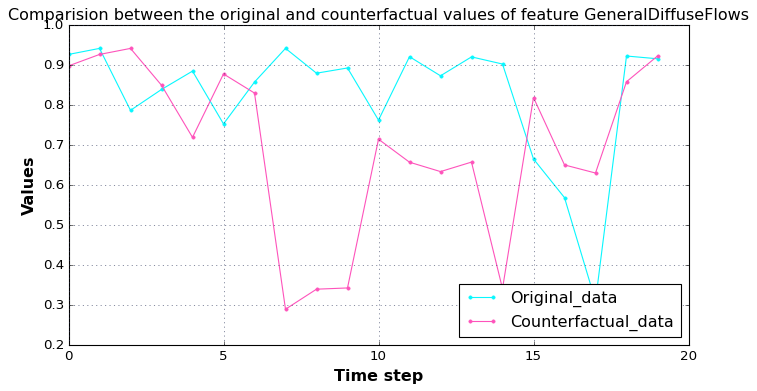

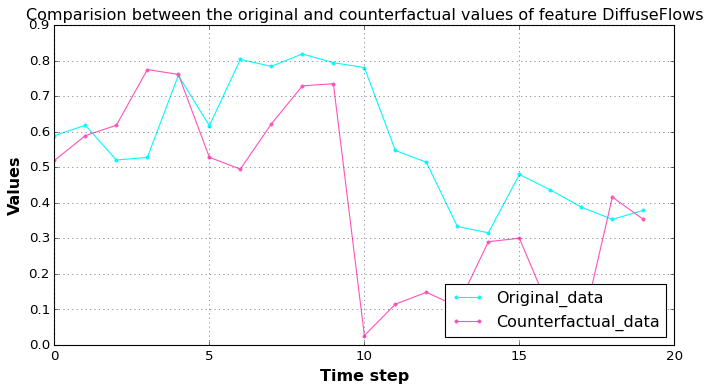

In [378]:
ex.VisualizeComparision(cefs2,index=0,startTime=0)

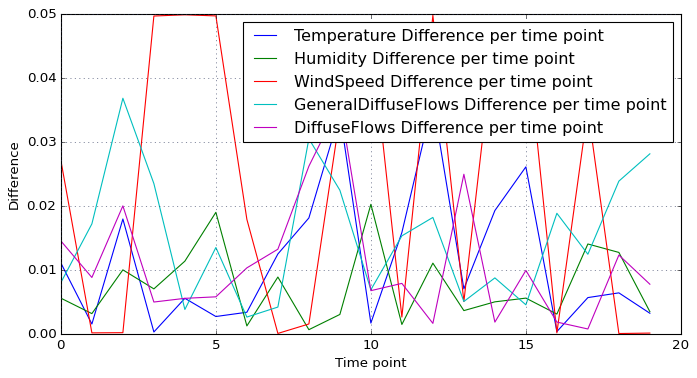

In [49]:
ex.VisualizeDifferencePerTime(cefs2,9)

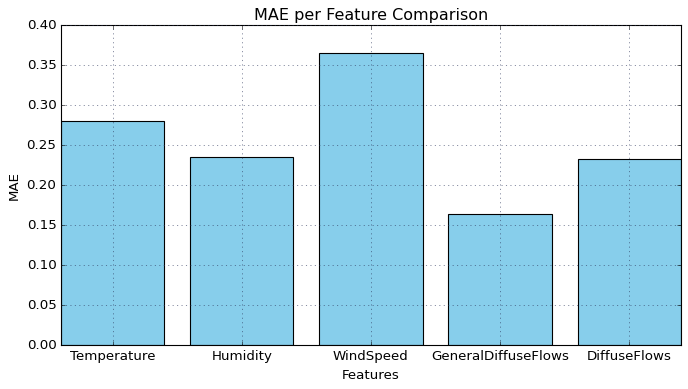

In [382]:
ex.VisualizeMAEPerFeature(cefs2,3)

analysing...: 100%|██████████| 5/5 [00:01<00:00,  3.59it/s]


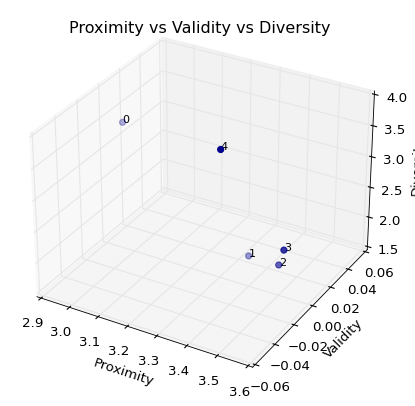

In [380]:
ex.VisualizeDistribution(cefs2)

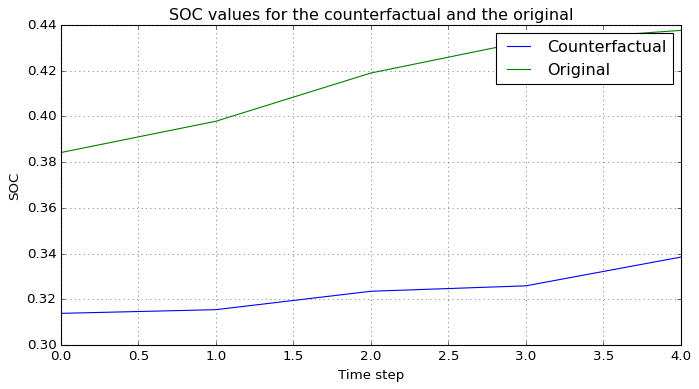

In [383]:
ex.VisualizePrediction(cefs,3,"SOC")